In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [39]:
# Load data from csv file
data = pd.read_csv('nasdag_selected.csv')
data_nasdag = data.copy()
data_nasdag.head()

,Date,Ticker,Low,Open,Volume,High,Close,AdjustedClose
0,1970-01-02,GT,15.125,15.3750,64600,15.8750,15.7500,3.40241
1,1970-01-05,GT,15.250,15.6875,47200,15.6875,15.4375,3.33490
2,1970-01-06,GT,14.750,15.1875,122000,15.1875,15.0000,3.24039
3,1970-01-07,GT,14.625,14.9375,45600,14.9375,14.8125,3.19989
4,1970-01-08,GT,14.625,14.8125,50400,14.9375,14.7500,3.18639


In [ ]:
len(data_nasdag.columns)

8

In [ ]:
data = data_nasdag.iloc[:5, slice(None,4)]
data

,Date,Ticker,Low,Open
0,1970-01-02,GT,15.125,15.3750
1,1970-01-05,GT,15.250,15.6875
2,1970-01-06,GT,14.750,15.1875
3,1970-01-07,GT,14.625,14.9375
4,1970-01-08,GT,14.625,14.8125


In [40]:
import preprocess as pp

In [41]:
samples = pp.get_data_samples_ks_day(data_nasdag, 5, slice(2,None))

In [42]:
X_data = samples[0]
y_data = samples[1]
print(y_data[0])

[13.25  13.375 13.125 13.    13.   ]


In [ ]:
splited_sets = pp.split_data(X_data, y_data)
X_train = splited_sets[0]
X_val = splited_sets[1]
X_test = splited_sets[2]

y_train = splited_sets[3]
y_val = splited_sets[4]
y_test = splited_sets[5]

In [ ]:
y_train.shape

(8524, 5)

In [ ]:
y_train

array([[13.25  , 13.375 , 13.125 , 13.    , 13.    ],
       [13.375 , 13.125 , 13.    , 13.    , 12.8125],
       [13.125 , 13.    , 13.    , 12.8125, 13.25  ],
       ...,
       [ 6.7   ,  6.72  ,  6.72  ,  6.86  ,  6.57  ],
       [ 6.72  ,  6.72  ,  6.86  ,  6.57  ,  6.57  ],
       [ 6.72  ,  6.86  ,  6.57  ,  6.57  ,  6.33  ]])

In [ ]:
# Reshape the numpy array to fit the neural network input shape requirement
window_size = 30
X_train = X_train.reshape(X_train.shape[0], window_size, 6)
X_val = X_val.reshape(X_val.shape[0], window_size, 6)
X_test = X_test.reshape(X_test.shape[0], window_size, 6)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)
print()
print("Shape of training set: ", y_train.shape)
print("Shape of validation set: ", y_val.shape)
print("Shape of test set: ", y_test.shape)

Shape of training set:  (8524, 30, 6)
Shape of validation set:  (2132, 30, 6)
Shape of test set:  (2665, 30, 6)

Shape of training set:  (8524, 5)
Shape of validation set:  (2132, 5)
Shape of test set:  (2665, 5)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# in this code i create 6 scaler for 6 feature, and 1 scaler for all the y data. The issue is that I should use param(scaler) by fitting x to
# transform y using that param. But now i have 6 params for x and i just need 1 param for y. so how to handle this.
# Initialize the MinMaxScaler for each feature
#y_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
# Reshape each feature (axis=-1) for scaling
X_train_norm = X_train.copy()
X_val_norm = X_val.copy()
X_test_norm = X_test.copy()

# Loop through each feature (axis=2) and scale across time and samples
for i in range(X_train.shape[2]):
    # Flatten the data for the i-th feature and apply MinMaxScaler
    scaler = MinMaxScaler()
    X_train_norm[:, :, i] = scaler.fit_transform(X_train[:, :, i])
    X_val_norm[:, :, i] = scaler.transform(X_val[:, :, i])
    X_test_norm[:, :, i] = scaler.transform(X_test[:, :, i])

    y_train_norm = y_scaler.fit_transform(y_train)
    y_val_norm = y_scaler.transform(y_val)
    y_test_norm = y_scaler.transform(y_test)


# Check the new shapes (they should remain the same as before)
print("Shape of scaled training set: ", X_train_norm.shape)
print("Shape of scaled validation set: ", X_val_norm.shape)
print("Shape of scaled test set: ", X_test_norm.shape)
print()
print("Shape of scales training label ", y_train_norm.shape)
print("Shape of scales validation label ", y_val_norm.shape)
print("Shape of scales test label ", y_test_norm.shape)

Shape of scaled training set:  (8524, 30, 6)
Shape of scaled validation set:  (2132, 30, 6)
Shape of scaled test set:  (2665, 30, 6)

Shape of scales training label  (8524, 5)
Shape of scales validation label  (2132, 5)
Shape of scales test label  (2665, 5)


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model_1d = tf.keras.Sequential()
model_1d.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 6), padding='same'))
model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))

model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model_1d.add(MaxPooling1D(pool_size=2))

model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model_1d.add(MaxPooling1D(2))

model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model_1d.add(MaxPooling1D(2))

model_1d.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model_1d.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model_1d.add(MaxPooling1D(2))

model_1d.add(Flatten())
model_1d.add(Dense(100, activation='relu'))
model_1d.add(Dense(5, activation='linear')) # By default: activation='linear', i.e., passing through f(x) = x

model_1d.summary()
model_1d.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 30, 64)              │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 30, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 15, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 15, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 15, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 15, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 7, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 7, 128)              │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 7, 128)              │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 7, 128)              │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 3, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 3, 256)              │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 606,557 (2.31 MB)

 Trainable params: 606,557 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_1d.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
#history = model_1d.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm))#, epochs=5, batch_size=512)

In [ ]:
mc = keras.callbacks.ModelCheckpoint(filepath="/content/model_1d.keras", # Path to save the model
                                     monitor='val_loss', # Metric to evaluate the model performance when looking for a better model.
                                     mode='min', # mode='auto'/'max'/'min': the monitor should be max/min to be better.
                                                 # In auto mode, the mode is set to max if the quantities monitored are 'acc' or start with 'fmeasure' (f-score) and are set to min for the rest of the quantities.
                                     verbose=0, # Inform every time a better model is found and saved.
                                     save_best_only=True) # Only save the model if the current training epoch is the best. 'False' means save models of all training epochs

# Train the model. Using Colab for training
history = model_1d.fit(X_train_norm, y_train_norm, # Data feature and data label
                    batch_size=512, # Batch size
                    epochs=20, # Number of training epochs
                    validation_data=(X_val_norm, y_val_norm), # Validation set
                    callbacks=[mc]) # Use callback ModelCheckpoint during the training



Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 769ms/step - loss: 0.0884 - mae: 0.2150 - val_loss: 0.0126 - val_mae: 0.0777
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 644ms/step - loss: 0.0510 - mae: 0.1597 - val_loss: 0.0069 - val_mae: 0.0751
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 773ms/step - loss: 0.0043 - mae: 0.0527 - val_loss: 0.0013 - val_mae: 0.0277
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 784ms/step - loss: 0.0016 - mae: 0.0310 - val_loss: 8.9721e-04 - val_mae: 0.0222
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 613ms/step - loss: 8.1707e-04 - mae: 0.0198 - val_loss: 8.5691e-04 - val_mae: 0.0214
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 697ms/step - loss: 6.8002e-04 - mae: 0.0172 - val_loss: 6.8647e-04 - val_mae: 0.0188
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 689ms/step - loss: 7.1996e-04 - mae: 0.0171 - val_loss: 6.2025e-04 - val_mae: 0.0181
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 721ms/step - loss: 5.9550e-04 - mae: 0.0157 - val_loss: 5.8425e-04 - val_mae: 0.0176
Epoch 9/20
1

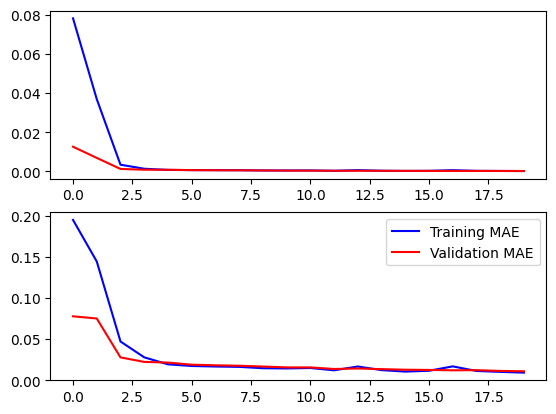

In [ ]:
# Visualize training and validation performance
f,ax=plt.subplots(2,1)

# Plot training and validation loss
ax[0].plot(history.history['loss'], color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

# Plot training and validation accuracy
ax[1].plot(history.history['mae'],color='b',label='Training MAE')
ax[1].plot(history.history['val_mae'],color='r',label='Validation MAE')

plt.legend()

In [ ]:
# Let us load a saved model and evaluate its performance on the test set
model_1d = tf.keras.models.load_model("/content/model_1d.keras")
result_1d = model_1d.evaluate(X_test_norm, y_test_norm) # If unspecified, batch_size will default to 32
# Show the model performance
print(model_1d.metrics_names) # result_1d[0] is loss, result_1d[1] is mse. The metrics are defined in model_1d.complie(...)
print("Loss and mae on the test set: loss = {}, mae = {}".format(result_1d[0],result_1d[1]))
# CONVO1D MODEL
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model_1d.predict(X_test_norm)


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.7431e-04 - mae: 0.0097
['loss', 'compile_metrics']
Loss and mae on the test set: loss = 0.00022479461040347815, mae = 0.010612599551677704
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [ ]:
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))
# Now, to denormalize the norm data back to the original scale:
y_pred_denorm = y_scaler.inverse_transform(y_pred_norm)

# Check the shapes
print("Shape of denormalized training set: ", y_pred_denorm.shape)

MSE on the test set:  0.000224794635215867
Shape of denormalized training set:  (2665, 5)


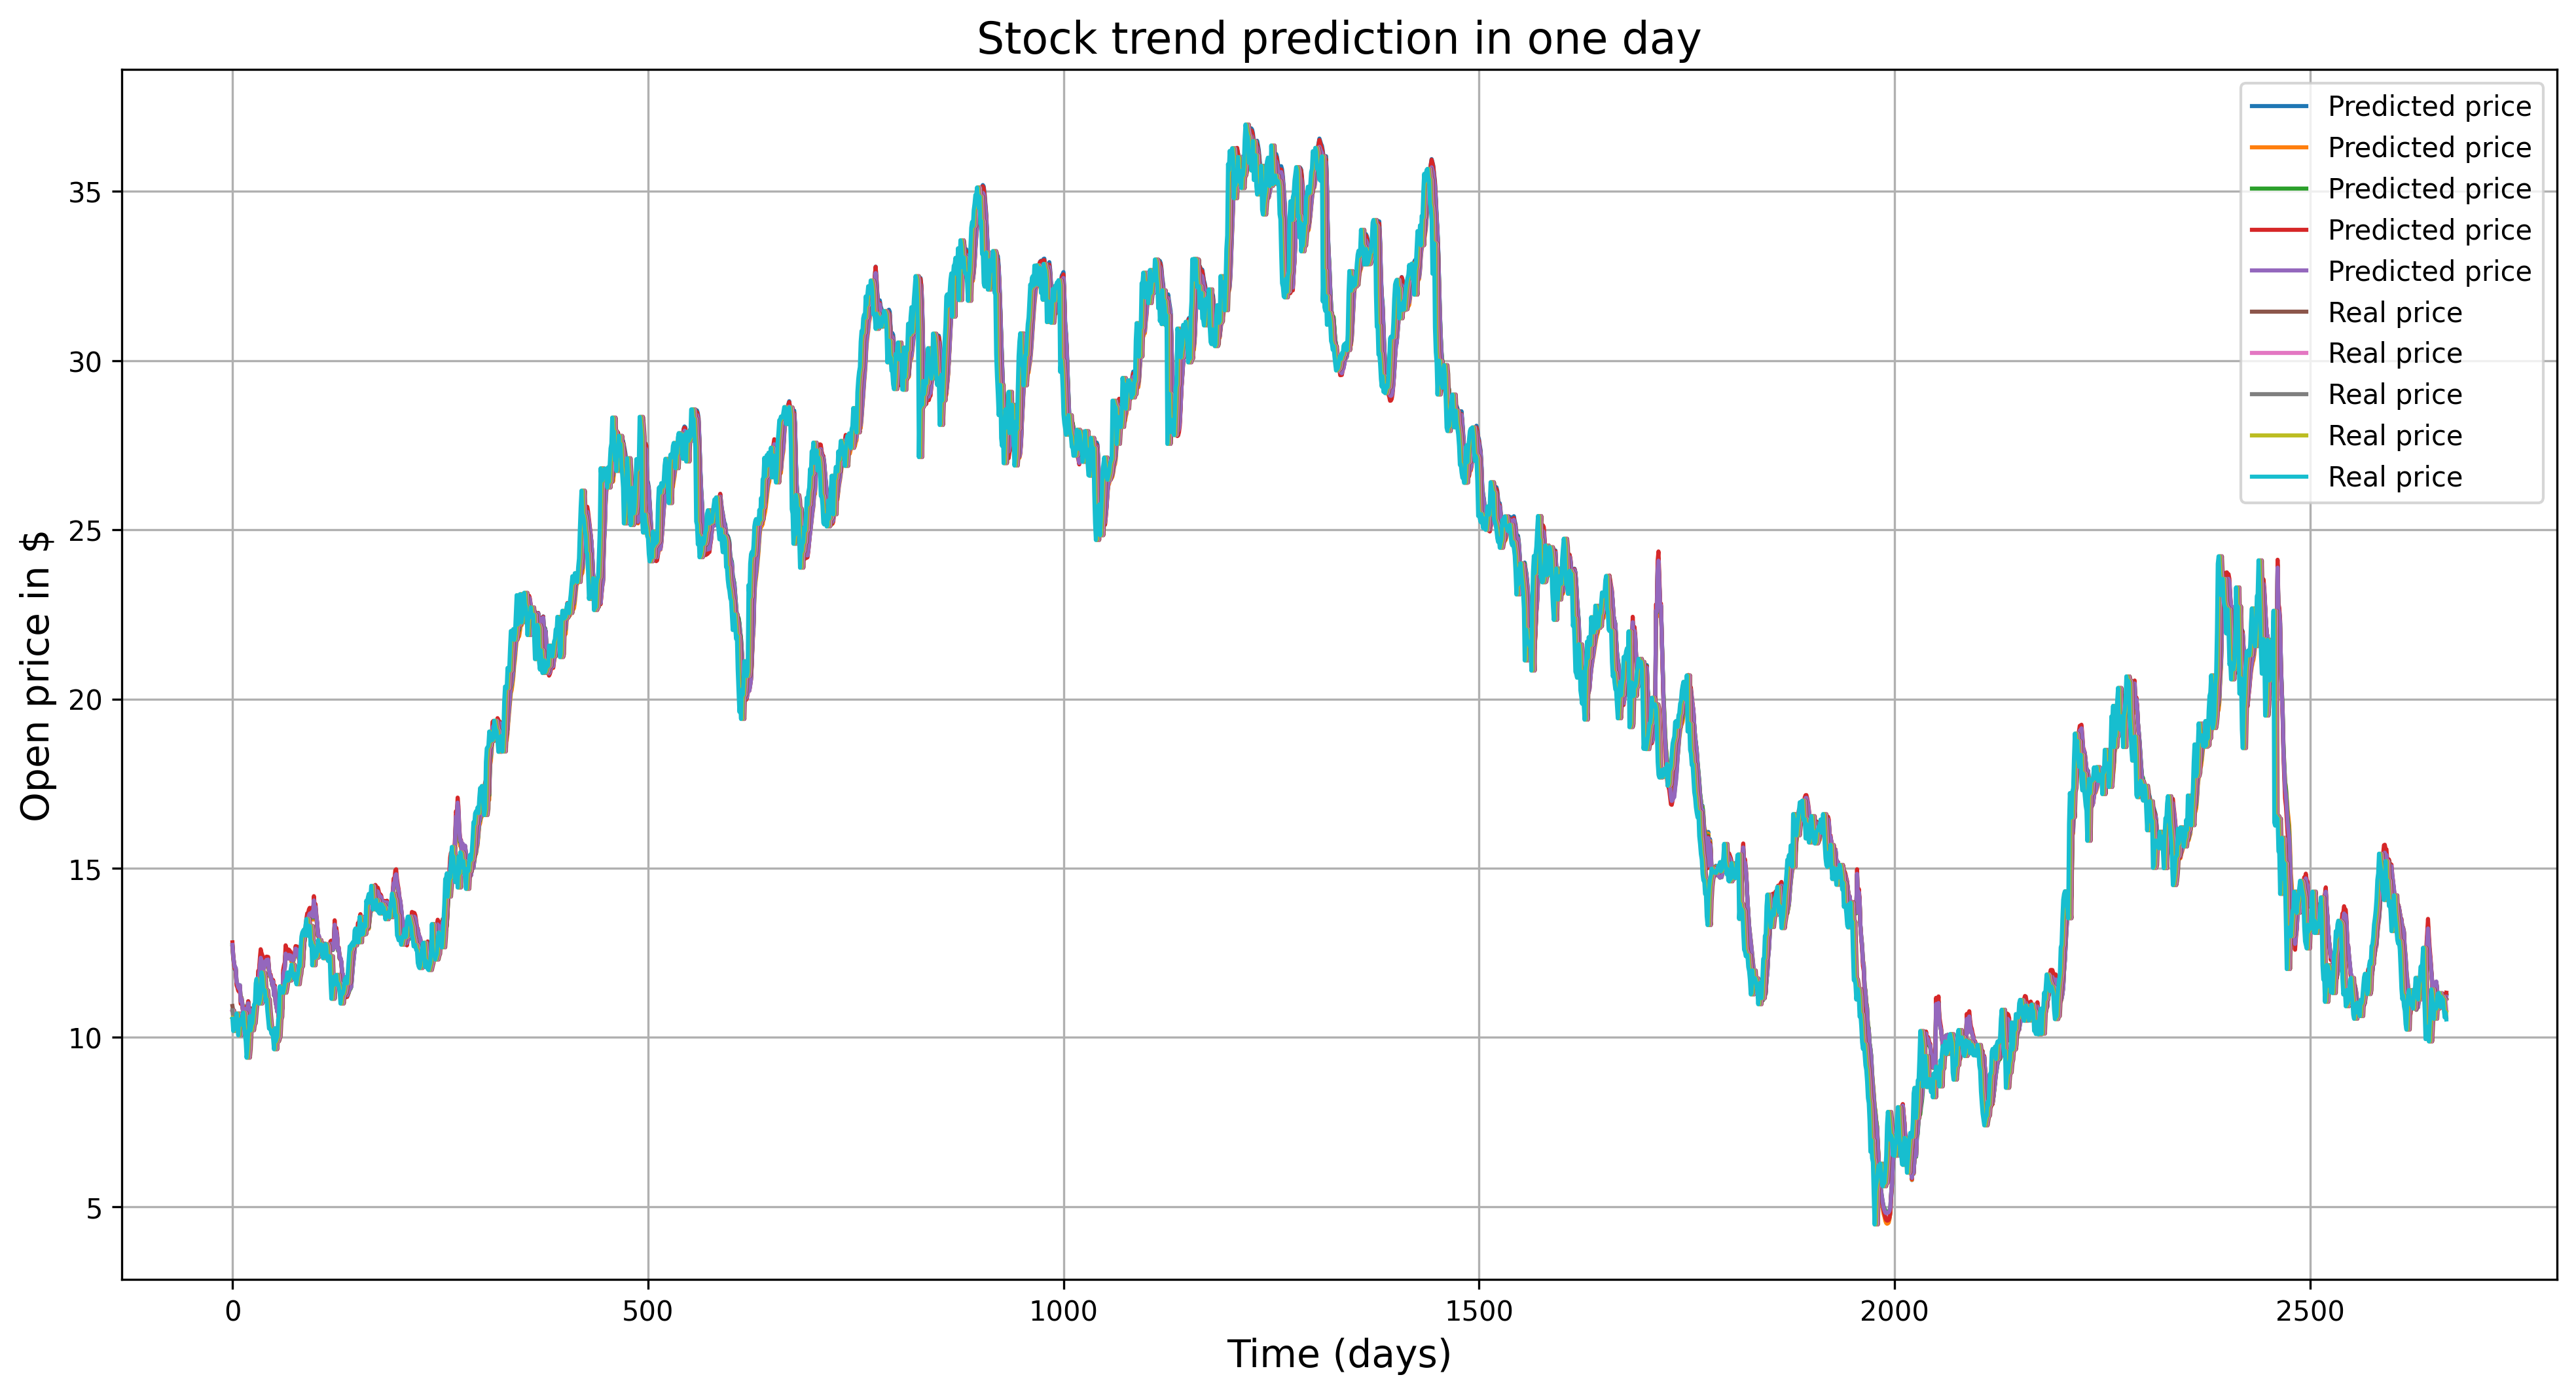

In [ ]:
# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

In [ ]:
time_steps = np.arange(0, 5)

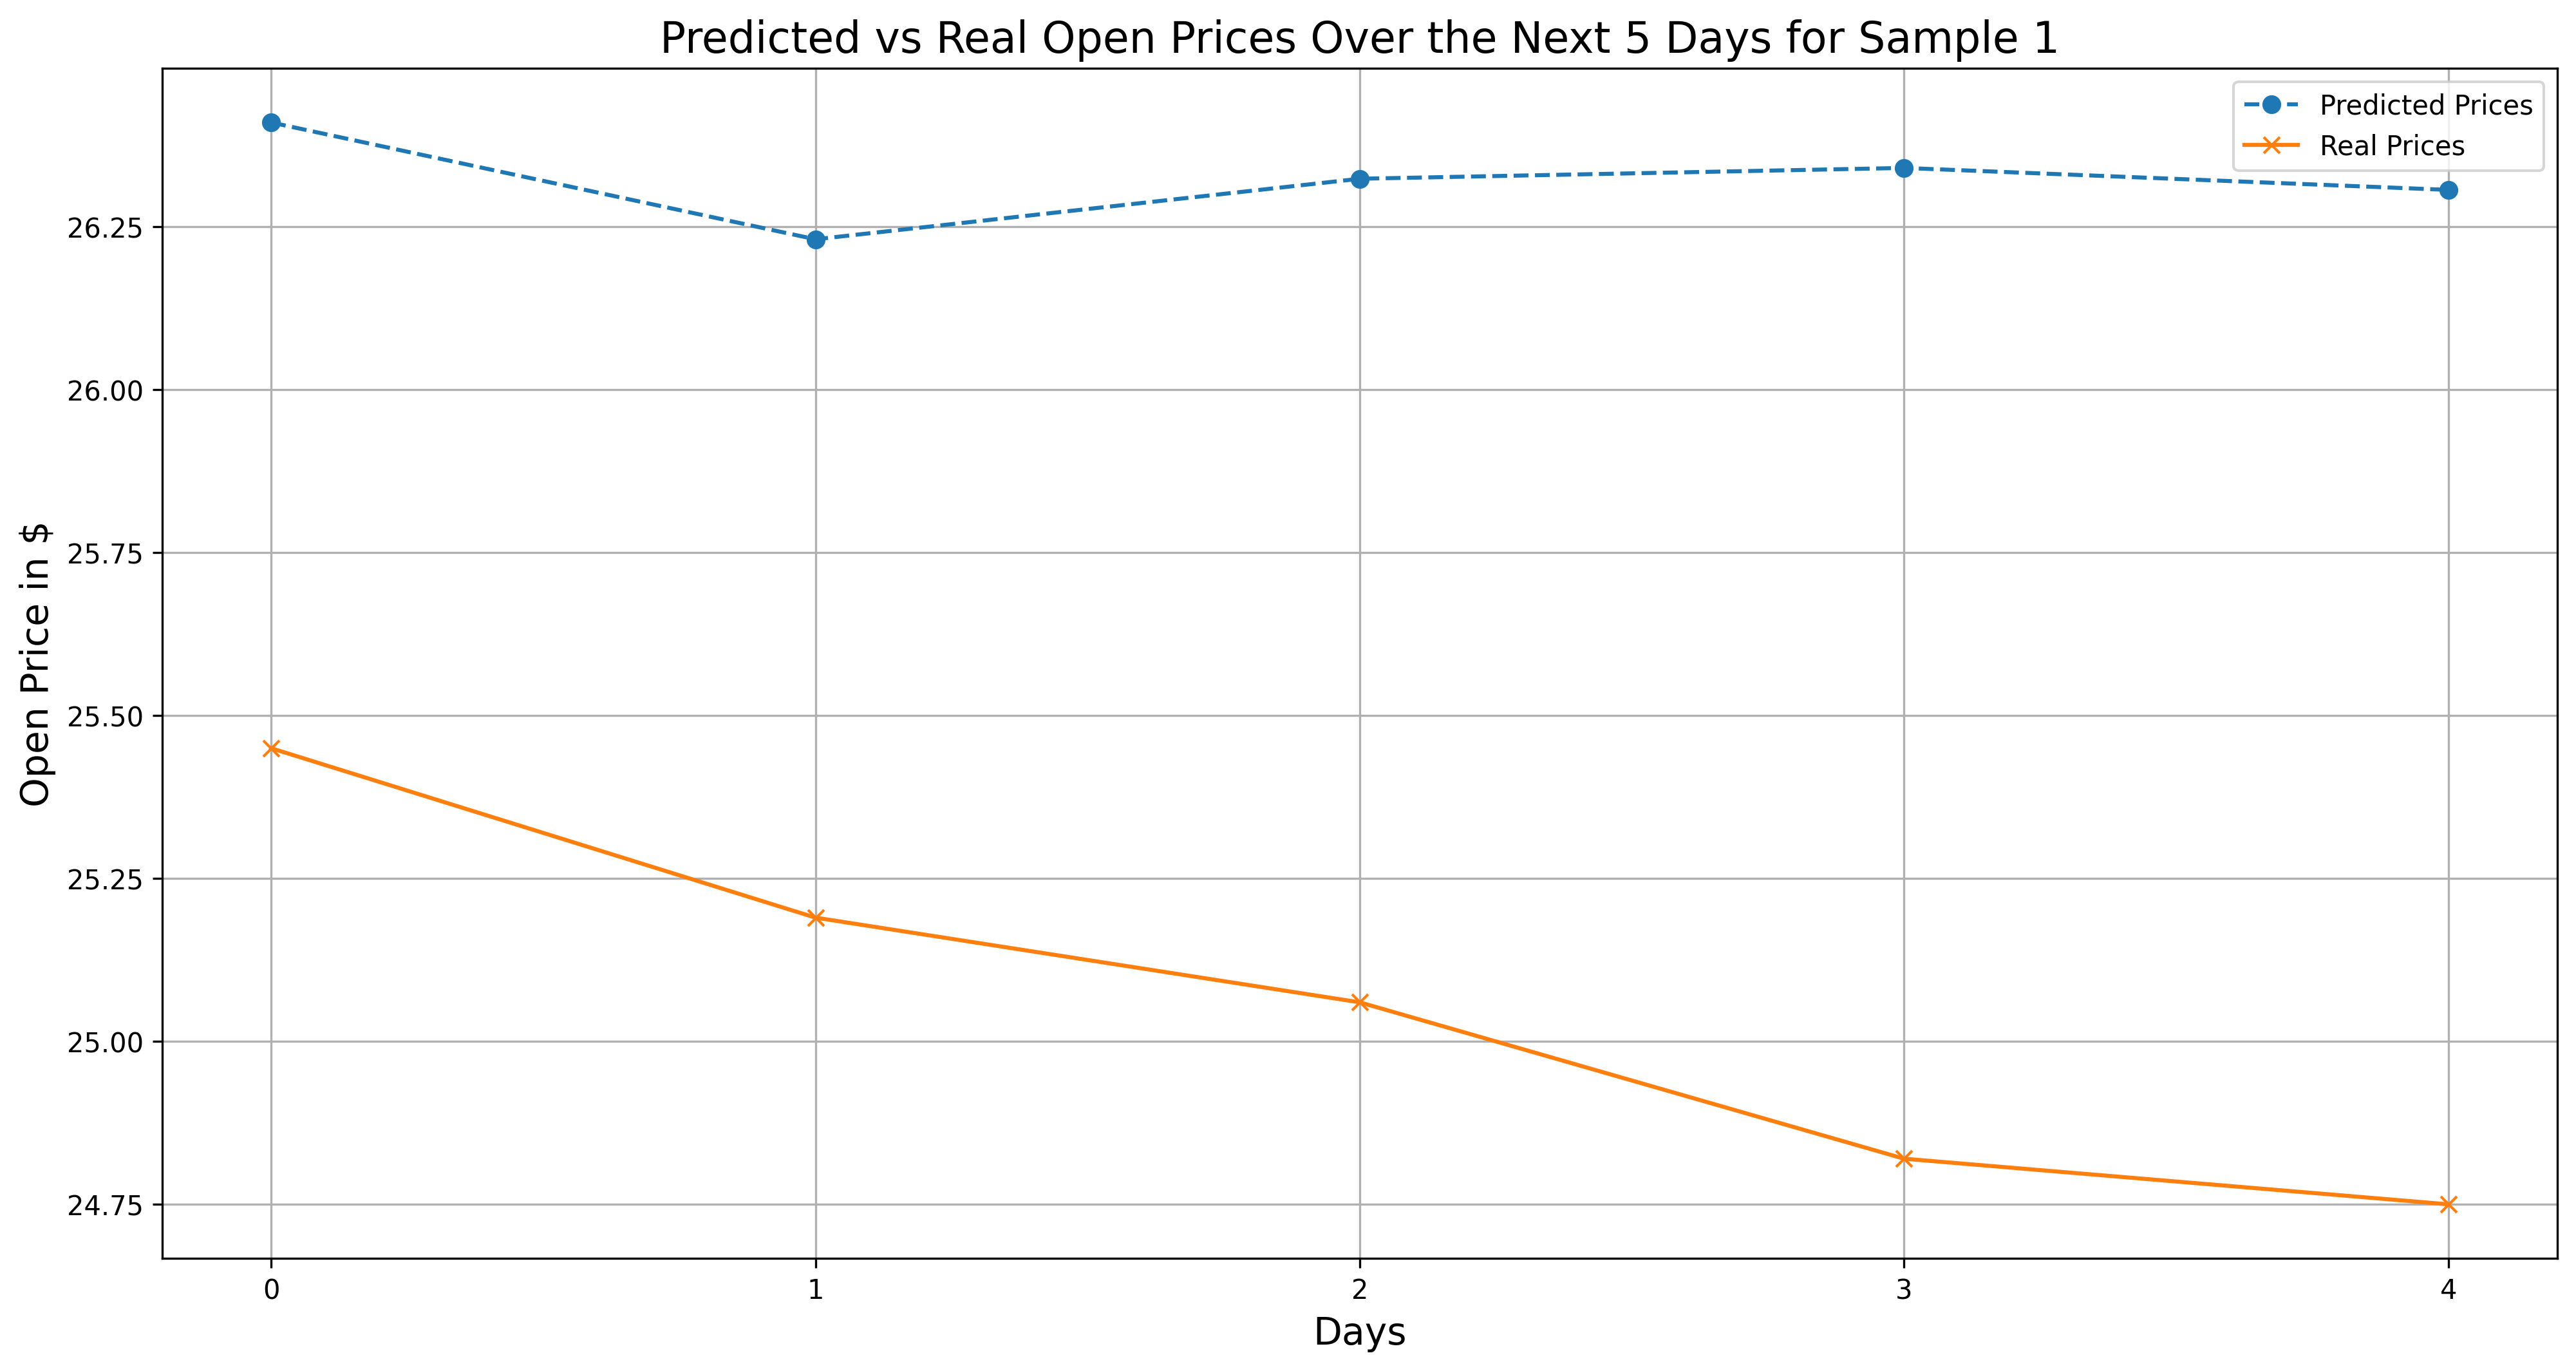

In [ ]:
plt.figure(figsize=(16, 8), dpi=300)

# Plot for the first sample only
plt.plot(time_steps, y_pred_denorm[500], label='Predicted Prices', linestyle='--', marker='o')
plt.plot(time_steps, y_test[500], label='Real Prices', linestyle='-', marker='x')

# Add titles, labels, and legend
plt.title('Predicted vs Real Open Prices Over the Next 5 Days for Sample 1', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Open Price in $', fontsize=14)
plt.xticks(time_steps)  # Set x-ticks to represent days
plt.grid()  # Add grid
plt.legend()  # Add legend
plt.show()
